In [1]:
import torch
import numpy as np
import random

import wandb
from NIK.datasets.knee import KneeDataset
from NIK.models.siren import NIKSiren
from torch.utils.data import DataLoader
import yaml

import matplotlib.pyplot as plt

In [2]:
# load in the config and the run number - update the run number for th next epoch. 
path_config = '/Users/gattia/Documents/Data/dynamic_mri_recon/NIK_MRI/configs/config_knee_laptop.yml'
with open(path_config, 'r') as stream:
    config = yaml.safe_load(stream)

with open(config['path_run_num'], 'r') as f:
    run_num = yaml.load(f, Loader=yaml.FullLoader)['number']

config['run_number'] = run_num

# update run_num
with open(config['path_run_num'], 'w') as f:
    yaml.dump({'number': run_num + 1}, f)

print(f'Run number: {run_num}')


Run number: 20


In [3]:
# set seed parameters for reproducibility

# enable Double precision
torch.set_default_dtype(torch.float32)

# set gpu and random seed
# torch.cuda.set_device(args.gpu)
random.seed(config['seed'])
np.random.seed(config['seed'])
torch.random.manual_seed(config['seed'])

In [4]:
# create the dataloader 
coils = [4,5,6,12,13,14]
config['coil_select'] = coils

# create dataset
dataset = KneeDataset(
    path_ktraj=config['path_ktraj'],
    path_kdata=config['path_kdata'],
    coils=coils
)

dataloader = DataLoader(
    dataset, 
    batch_size=config['batch_size'], 
    shuffle=True, 
    num_workers=config['num_workers']
)

/Users/gattia/Documents/Data/dynamic_mri_recon/NIK_MRI/NIK/datasets/knee.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  kcoords[:, :, :, 2] = ktraj[0, :][None]
/Users/gattia/Documents/Data/dynamic_mri_recon/NIK_MRI/NIK/datasets/knee.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  kcoords[:, :, :, 3] = ktraj[1, :][None]
/Users/gattia/Documents/Data/dynamic_mri_recon/NIK_MRI/NIK/datasets/knee.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  kcoords[:, :, :, 4] = ktraj[2, :][None]


In [5]:
# plot distribution of the k-space data to make sure
# that it looks like it should - that is, the k-space values
# near the center (0,0,0) should have higher magnitude than
# those further away.

# the k-space values should have certain structure. Can 
# you help me plot/see what the k-space values are (magnitude)
# as a function of their distance from the k-space center? 

# get a batch of data
sample = next(iter(dataloader))

ktraj = sample['coords']
kdata = sample['targets']


torch.Size([30000, 5]) torch.Size([30000, 1])


Text(0, 0.5, 'k-space magnitude')

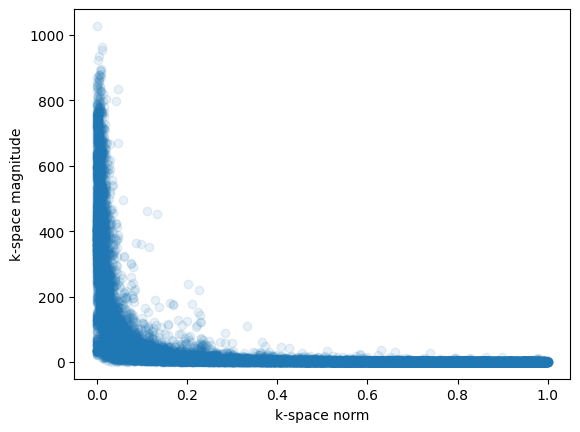

In [6]:
print(ktraj.shape, kdata.shape)

# get the norm of the kspace trajectory: 
ktraj_norm = torch.norm(ktraj[...,2:], dim=-1)

# plt scatter plot
plt.figure()
plt.scatter(ktraj_norm, kdata.abs().flatten(), alpha=0.1)
plt.xlabel('k-space norm')
plt.ylabel('k-space magnitude')

In [7]:
# build the neural implicit k-space model 
NIKmodel = NIKSiren(config)

NIKmodel.init_train()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aagatti. Use `wandb login --relogin` to force relogin


In [8]:
NIKmodel.smaps.shape

torch.Size([200, 200, 30, 6])

In [9]:
# from NIK.utils.mri import ifft3c_mri
# ifft3c_mri(kpred[1,3]).shape

In [16]:
# max_iter = 10
# train the model 
for epoch in range(config['num_steps']):
    print(f"Epoch: {epoch}")
    loss_epoch = 0
    for i, sample in enumerate(dataloader):
        # kcoord, kv = sample['coords'], sample['target']
        loss = NIKmodel.train_batch(sample)
        print(f"Epoch: {epoch}, Iter: {i}, Loss: {loss}")
        loss_epoch += loss
        
        # if i > max_iter:
        #     break
        
    
    kpred = NIKmodel.recon_kspace()
    dict_images = NIKmodel.recon_images(kpred=kpred)
    # all images are formatted as t, x, y, z
    # going to log them as videos which should be
    # in format [t, c, x, y], or [batch, t, c, h, w]
    # where h, w, are the height and width of the image
    # and t, c are the number of time steps and the 
    # channels as in rgb. We will flatten c to be 1
    # to make grayscale, and use our time as time, but
    # move our slice to be batch. 
    
    # get slice 15 (The center slice) for all 
    # examples, and then expand the dimensions 
    # to add a length 1 channel dimension. 
    kmag = dict_images['k_mag'][:,:,:,15]
    # kmag = kmag.unsqueeze(1)
    kmag = np.expand_dims(kmag, axis=1)
    img = dict_images['combined_mag'][:,:,:,15]
    # img = img.unsqueeze(1)
    # img = np.expand_dims(img, axis=1)
    # phase = dict_images['combined_phase'][:,:,:,15]
    # phase = phase.unsqueeze(1)    
    num_frames = kmag.shape[0]
    # selected_indices = np.linspace(0, num_frames - 1, 5, dtype=int)

    log_dict = {
        'loss': loss_epoch/len(dataloader),
        'k': [wandb.Image(kmag[i]) for i in range(kmag.shape[0])],
        'img': [wandb.Image(img[i]) for i in range(img.shape[0])],
        # 'img_phase': [wandb.Image(phase[i]) for i in selected_indices],  # Uncomment if needed
        'khist': wandb.Histogram(torch.view_as_real(kpred).detach().cpu().numpy().flatten()),
    }

    # log_dict = {
    #     'loss': loss_epoch/len(dataloader),
    #     'k': wandb.Video(kmag, fps=10, format="gif"),
    #     'img': wandb.Video(img, fps=10, format="gif"),
    #     # 'img_phase': wandb.Video(phase, fps=10, format="gif"),
    #     'khist': wandb.Histogram(torch.view_as_real(kpred).detach().cpu().numpy().flatten()),
    # }
    
    NIKmodel.exp_summary_log(log_dict)
    print(f'\tloss: {log_dict["loss"]}')


Epoch: 0
Epoch: 0, Iter: 0, Loss: 1756.13818359375
Epoch: 0, Iter: 1, Loss: 1741.482666015625
Epoch: 0, Iter: 2, Loss: 1703.3714599609375
Epoch: 0, Iter: 3, Loss: 1681.33447265625
Epoch: 0, Iter: 4, Loss: 1679.7884521484375
Epoch: 0, Iter: 5, Loss: 1736.92138671875
Epoch: 0, Iter: 6, Loss: 1632.997314453125
Epoch: 0, Iter: 7, Loss: 1688.84814453125
Epoch: 0, Iter: 8, Loss: 1705.2017822265625
Epoch: 0, Iter: 9, Loss: 1657.531494140625
Epoch: 0, Iter: 10, Loss: 1595.1488037109375
Epoch: 0, Iter: 11, Loss: 1691.387451171875
Epoch: 0, Iter: 12, Loss: 1644.045166015625
Epoch: 0, Iter: 13, Loss: 1721.5440673828125
Epoch: 0, Iter: 14, Loss: 1736.01416015625
Epoch: 0, Iter: 15, Loss: 1768.0302734375
Epoch: 0, Iter: 16, Loss: 1757.903076171875
Epoch: 0, Iter: 17, Loss: 1698.951171875
Epoch: 0, Iter: 18, Loss: 1727.986328125
Epoch: 0, Iter: 19, Loss: 1602.1123046875
Epoch: 0, Iter: 20, Loss: 1701.7939453125
Epoch: 0, Iter: 21, Loss: 1628.855224609375
Epoch: 0, Iter: 22, Loss: 1655.3065185546875


In [12]:
log_dict = {
    'k': [wandb.Image(kmag[i]) for i in range(kmag.shape[0])],
    'img': [wandb.Image(img[i]) for i in range(img.shape[0])],
    # 'img_phase': [wandb.Image(phase[i]) for i in selected_indices],  # Uncomment if needed
    'khist': wandb.Histogram(torch.view_as_real(kpred).detach().cpu().numpy().flatten()),
}

NIKmodel.exp_summary_log(log_dict)

In [14]:
run_num

20

In [ ]:
# Create cartesian k-space trajectory and then
# apply the model to get the k-space data for
# each coordinate.


# create the k-space trajectory as just the 
# density we want along each of the x-y-z, time
# and coil dimensions. Do this in a nested for
# loop over time and coil dimensions. For each 
# inner loop apply the ifft to the 3D kspace data
# to get the image data. Then apply the images
# by the coil sensitivity maps and sum them up.

config['nt'] = 5 

with torch.no_grad():

    nt  = config['nt']
    nx = config['nx']
    ny = config['ny']
    nz = config['nz']
    nc = len(NIKmodel.config['coil_select'])

    ts = torch.linspace(-1+1/nt, 1-1/nt, nt)
    kc = torch.linspace(-1, 1, nc)
    kxs = torch.linspace(-1, 1-2/nx, nx)
    kys = torch.linspace(-1, 1-2/ny, ny)
    kzs = torch.linspace(-1, 1-2/nz, nz)

    grid_coords = torch.stack(torch.meshgrid(ts, kc, kxs, kys, kzs, indexing='ij'), -1).to(NIKmodel.device)
    dist_to_center = torch.sqrt(grid_coords[:,:,:,:,:,2]**2 + grid_coords[:,:,:,:,:,3]**2 + grid_coords[:,:,:,:,:,4]**2)
    
    grid_coords = grid_coords.reshape(-1, config['coord_dim']).requires_grad_(False)
    
    # t_split = 1020
    # t_split_num = np.ceil(nt / t_split).astype(int)
    batch_size = 30_000
    splits = np.ceil(grid_coords.shape[0] / batch_size).astype(int)
    
    print(f"Total number of splits: {splits}")

    kpred_list = []
    for t_batch in range(splits):
        # every 20 iterations, log the progress
        if t_batch % 20 == 0:
            print(f"Progress: {t_batch}/{splits}")
        
        grid_coords_batch = grid_coords[t_batch*batch_size:(t_batch+1)*batch_size]

        # grid_coords_batch = grid_coords_batch.reshape(-1, config['coord_dim']).requires_grad_(False)
        # get prediction
        sample = {'coords': grid_coords_batch}
        sample = NIKmodel.pre_process(sample)
        kpred_batch = NIKmodel.forward(sample)
        kpred_batch = NIKmodel.post_process(kpred_batch)
        kpred_list.append(kpred_batch)
    kpred = torch.concat(kpred_list, 0)
    
    kpred = kpred.reshape(nt, nc, nx, ny, nz)
    k_outer = 1
    # kpred[dist_to_center>=k_outer] = 0

    # kpred_list.append(kpred)
    # kpred = torch.mean(torch.stack(kpred_list, 0), 0) #* filter_value.reshape(-1, 1)


In [ ]:
#read in the sensitivity maps
path_smaps = '/Users/gattia/Documents/Data/dynamic_mri_recon/data_extracted_marco/sens_maps.npy'
smaps = np.load(path_smaps)
print(smaps.shape)

In [ ]:
# reconstruct all slices using a single coil
# with and without the sensitivity maps

time_idx = 2
coil_idx = 2
coil_1_image = torch.fft.ifftn(kpred[time_idx,coil_idx], 30) #norm=True)

smap_idx = NIKmodel.config['coil_select'][coil_idx]
sense_map = smaps[:,:,:,smap_idx]

for slice_idx in range(coil_1_image.shape[2]):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    plt.title(slice_idx)
    image = torch.abs(coil_1_image[:,:,slice_idx]).cpu().numpy()
    image_ = image * sense_map[:,:,slice_idx]
    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(np.abs(image_), cmap='gray')
    # plt.colorbar()

In [ ]:
# plot each z slice of k space as a 1xn_coils subplot 
# to see what the kspace data looks like - this does not look great. 

time_idx = 2
nt, nc, nx, ny, nz = kpred.shape

for slice_idx in range(nz):
    fig, ax = plt.subplots(1, nc, figsize=(20,5))
    for coil_idx in range(nc):
        ax[coil_idx].imshow(np.abs(kpred[time_idx,coil_idx,:,:,slice_idx].cpu().numpy()), cmap='gray')
        #colorbar
        fig.colorbar(ax[coil_idx].imshow(np.abs(kpred[time_idx,coil_idx,:,:,slice_idx].cpu().numpy()), cmap='gray'))
    # create a colorbar
    
    



In [ ]:
# plot the fully reconstructed images with and without
# the sensitivity maps applied. 

time_idx = 2
nt, nc, nx, ny, nz = kpred.shape

# Initialize an empty tensor to accumulate the combined image
combined_image = np.zeros((nx, ny, nz), dtype=np.complex64)

# Iterate over each coil
for coil_idx in range(nc):
    # Perform inverse FFT for the current coil
    coil_image = torch.fft.ifftn(kpred[time_idx, coil_idx], dim=(-3, -2, -1), norm='ortho')  # Applying IFFT
    
    # Get the corresponding coil sensitivity map
    smap_idx = NIKmodel.config['coil_select'][coil_idx]
    sense_map = smaps[:,:,:,smap_idx]
    
    # Multiply coil image by its sensitivity map
    coil_image_with_sense = coil_image.cpu().numpy() * sense_map
    
    # Accumulate the result into the combined image
    combined_image += coil_image_with_sense

# Now, display the combined image for each slice
for slice_idx in range(combined_image.shape[2]):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    plt.title(f'Slice {slice_idx}')
    
    # Show the magnitude of the coil-specific and combined images
    coil_1_image_abs = torch.abs(coil_image[:,:,slice_idx]).cpu().numpy()  # For the single coil you were originally visualizing
    combined_image_abs = np.abs(combined_image[:,:,slice_idx])  # For the combined coil image
    
    ax[0].imshow(coil_1_image_abs, cmap='gray')  # Single coil image
    ax[1].imshow(combined_image_abs, cmap='gray')  # Combined coil image
    
    plt.show()


In [ ]:
def ifft3c_mri(k):
    x = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(k, (-3,-2,-1)), norm='ortho'), (-3,-2,-1))
    return x

# plot the fully reconstructed images with and without
# the sensitivity maps applied. 

time_idx = 2
nt, nc, nx, ny, nz = kpred.shape

# Initialize an empty tensor to accumulate the combined image
combined_image = np.zeros((nx, ny, nz), dtype=np.complex64)

# Iterate over each coil
for coil_idx in range(nc):
    # Perform inverse FFT for the current coil
    coil_image = ifft3c_mri(kpred[time_idx, coil_idx])  # Applying IFFT
    
    # Get the corresponding coil sensitivity map
    smap_idx = NIKmodel.config['coil_select'][coil_idx]
    sense_map = smaps[:,:,:,smap_idx]
    
    # Multiply coil image by its sensitivity map
    coil_image_with_sense = coil_image.cpu().numpy() * sense_map
    
    # Accumulate the result into the combined image
    combined_image += coil_image_with_sense

# Now, display the combined image for each slice
for slice_idx in range(combined_image.shape[2]):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    plt.title(f'Slice {slice_idx}')
    
    # Show the magnitude of the coil-specific and combined images
    coil_1_image_abs = torch.abs(coil_image[:,:,slice_idx]).cpu().numpy()  # For the single coil you were originally visualizing
    combined_image_abs = np.abs(combined_image[:,:,slice_idx])  # For the combined coil image
    
    ax[0].imshow(coil_1_image_abs, cmap='gray')  # Single coil image
    ax[1].imshow(combined_image_abs, cmap='gray')  # Combined coil image
    
    plt.show()


In [ ]:
smaps.shape

In [ ]:
# from utils.vis import angle2color, k2img

# def main():
#     # parse args and get config
#     parser = argparse.ArgumentParser()
#     parser.add_argument('-c', '--config', type=str, default='configs/config.yml')
#     parser.add_argument('-g', '--gpu', type=int, default=0)
#     parser.add_argument('-s', '--slice_name', type=str, default='CINE_S1_rad_AA')
#     parser.add_argument('-seed', '--seed', type=int, default=0)
#     # parser.add_argument('-s', '--seed', type=int, default=0)
#     args = parser.parse_args()



# parse config
# slice_name = args.slice_name
# config = parse_config(args.config)
# config['slice_name'] = slice_name
# config['gpu'] = args.gpu


# config['eps'] = dataset.eps
# create model
if config['model'] == 'siren':


for epoch in range(config['num_steps']):
loss_epoch = 0
for i, sample in enumerate(dataloader):
    # kcoord, kv = sample['coords'], sample['target']
    loss = NIKmodel.train_batch(sample)
    print(f"Epoch: {epoch}, Iter: {i}, Loss: {loss}")
    loss_epoch += loss


kpred = NIKmodel.test_batch()

# kpred[kpred != 0] = (dataset.eps / torch.abs(kpred[kpred != 0]) - dataset.eps) * (kpred[kpred != 0] / torch.abs(kpred[kpred != 0]))

vis_img = k2img(kpred, dataset.csm)

log_dict = {
    'loss': loss_epoch/len(dataloader),
    'k': wandb.Video(vis_img['k_mag'], fps=10, format="gif"),
    'img': wandb.Video(vis_img['combined_mag'], fps=10, format="gif"),
    'img_phase': wandb.Video(vis_img['combined_phase'], fps=10, format="gif"),
    'khist': wandb.Histogram(torch.view_as_real(kpred).detach().cpu().numpy().flatten()),
}
NIKmodel.exp_summary_log(log_dict)



if __name__ == '__main__':
    main()

In [ ]:
import torch

# Check if MPS is available (for Apple Silicon devices)
if torch.backends.mps.is_available():
    print("MPS (Metal Performance Shaders) device: Available")
else:
    print("MPS is not available. Using CPU or other devices.")

# Check if CUDA is available (for other setups with NVIDIA GPUs)
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Checking other options...")

# Always list the CPU
print("CPU: Available")